# As imagens para esse estudo foram retiradas do site do kaggle pelo link abaixo: https://www.kaggle.com/datasets/kmader/siim-medical-images

# Segmentação de imagens médicas - Notebook responsavel pelo estudo das técnicas classicas de segmentação e no final pela criação das imagens mask (serão usadas no treinamento para o eixo y)

# Importação das Bibliotecas

In [1]:
import os
import numpy as np
import cv2
from tqdm import tqdm
from matplotlib import pyplot as plt
import tensorflow
import random
from glob import glob
from skimage.io import imread
from skimage.color import rgb2gray
from google.colab.patches import cv2_imshow
tensorflow.__version__

'2.11.0'

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Transforma as imagens de .tif para png e salva na pasta png_images

In [ ]:
folder_old = '/content/gdrive/MyDrive/Segmentacao/medical-images/tiff_images/'
folder_new = '/content/gdrive/MyDrive/Segmentacao/medical-images/png_images/'

In [ ]:
for filename in os.listdir(folder_old):
    #Leitura do arquivo
    img = imread(os.path.join(folder_old,filename))    

    if img is not None:
  
      #gera o caminho do arquivo mask
      arquivo = os.path.join(folder_new, filename.replace('.tif', '.png'))      

      #Salva o arquivo mask no drive
      cv2.imwrite(arquivo, img)

In [7]:
def checa_imagem_cinza(img):
  if(len(img.shape)<3):
      return True
  else:
      return False  

# Analise de segmentação por região, por 2 regiões ficou melhor

In [12]:
def flatten_img(img):
  altura, largura = img.shape[0], img.shape[1]
  img_flat = img.reshape(altura * largura)
  return img_flat

In [13]:
def segmenta2regioes(img):
  pixels = flatten_img(img).copy()
  media = pixels.mean()
  for i in range(len(pixels)):
    if pixels[i] > media:
      pixels[i] = 255
    else:
      pixels[i] = 0
  seg_regiao = pixels.reshape(img.shape[0], img.shape[1])
  return seg_regiao

In [14]:
def segmenta3regioes(img):
  pixels = flatten_img(img).copy()
  for i in range(len(pixels)):
    if pixels[i] > 0.66:
      pixels[i] = 255
    elif pixels[i] > 0.33:
      pixels[i] = 127
    else:
      pixels[i] = 0
  seg_regiao = pixels.reshape(img.shape[0], img.shape[1])
  return seg_regiao

In [15]:
def segmenta4regioes(img):
  pixels = flatten_img(img).copy()
  for i in range(len(pixels)):
    if pixels[i] > 0.75:
      pixels[i] = 3
    elif pixels[i] > 0.5:
      pixels[i] = 2
    elif pixels[i] > 0.25:
      pixels[i] = 1
    else:
      pixels[i] = 0
  seg_regiao = pixels.reshape(img.shape[0], img.shape[1])
  return seg_regiao

In [16]:
def segmenta5regioes(img):
  pixels = flatten_img(img).copy()
  for i in range(len(pixels)):
    if pixels[i] > 0.8:
      pixels[i] = 4
    elif pixels[i] > 0.6:
      pixels[i] = 3
    elif pixels[i] > 0.4:
      pixels[i] = 2
    elif pixels[i] > 0.2:
      pixels[i] = 1
    else:
      pixels[i] = 0
  seg_regiao = pixels.reshape(img.shape[0], img.shape[1])
  return seg_regiao

In [18]:
def segmentacao_regiao(img, cmap='gray'):  
  img_float32 = np.float32(img)
  original = cv2.cvtColor(img_float32, cv2.COLOR_BGR2RGB)

  if (checa_imagem_cinza(img_float32) == False):
      gray = rgb2gray(img_float32)
  else:
      gray = img_float32

  segment2R = segmenta2regioes(gray)
  segment3R = segmenta3regioes(gray)
  segment4R = segmenta4regioes(gray)
  segment5R = segmenta5regioes(gray)
  
  titulos = ['Imagem Original', '2 Regiões', '3 Regiões', '4 Regiões', '5 Regiões', 'Original (1 canal)']
  imagens = [original, segment2R, segment3R, segment4R, segment5R, gray]

  fig = plt.gcf()
  fig.set_size_inches(18, 10)  
  for i in range(6):
      plt.subplot(2,3,i+1)
      plt.imshow(imagens[i], cmap) 
      plt.title(titulos[i]) 
      plt.xticks([]),plt.yticks([])
      
  plt.subplots_adjust(wspace=0.05)
  plt.show()

In [19]:
def mostrar(imagem):
  fig = plt.gcf()
  fig.set_size_inches(10,6)
  plt.imshow(imagem, cmap='gray')  
  plt.axis('off')
  plt.show()

In [20]:
img = imread('/content/gdrive/MyDrive/Segmentacao/medical-images/tiff_images/ID_0001_AGE_0069_CONTRAST_1_CT.tif')

In [21]:
img_float32 = np.float32(img)
original = cv2.cvtColor(img_float32, cv2.COLOR_BGR2RGB)

if (checa_imagem_cinza(img_float32) == False):
  gray = rgb2gray(img_float32)
else:
  gray = img_float32
   

In [22]:
seg2 = segmenta2regioes(gray)

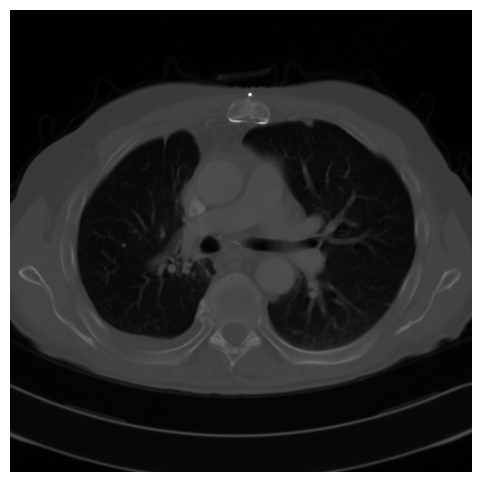

In [23]:
mostrar(img)

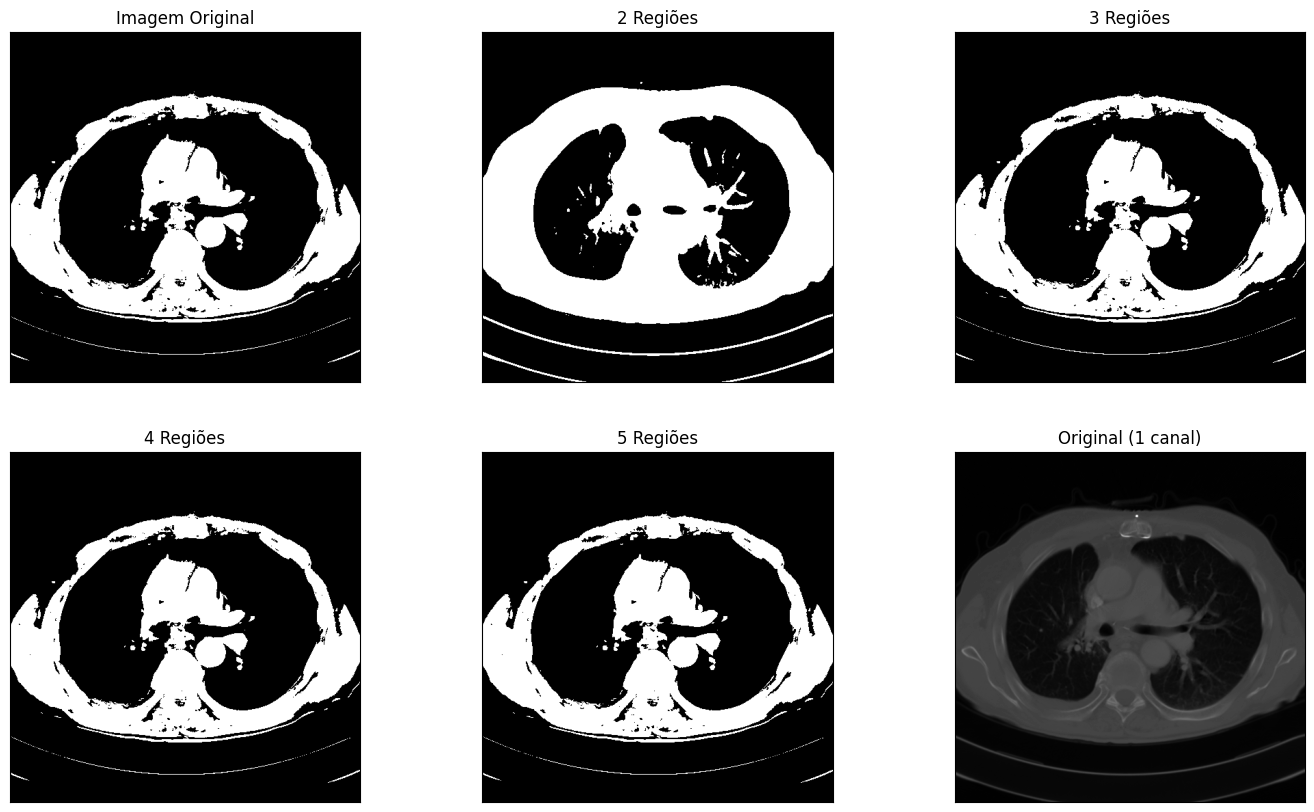

In [24]:
segmentacao_regiao(img)

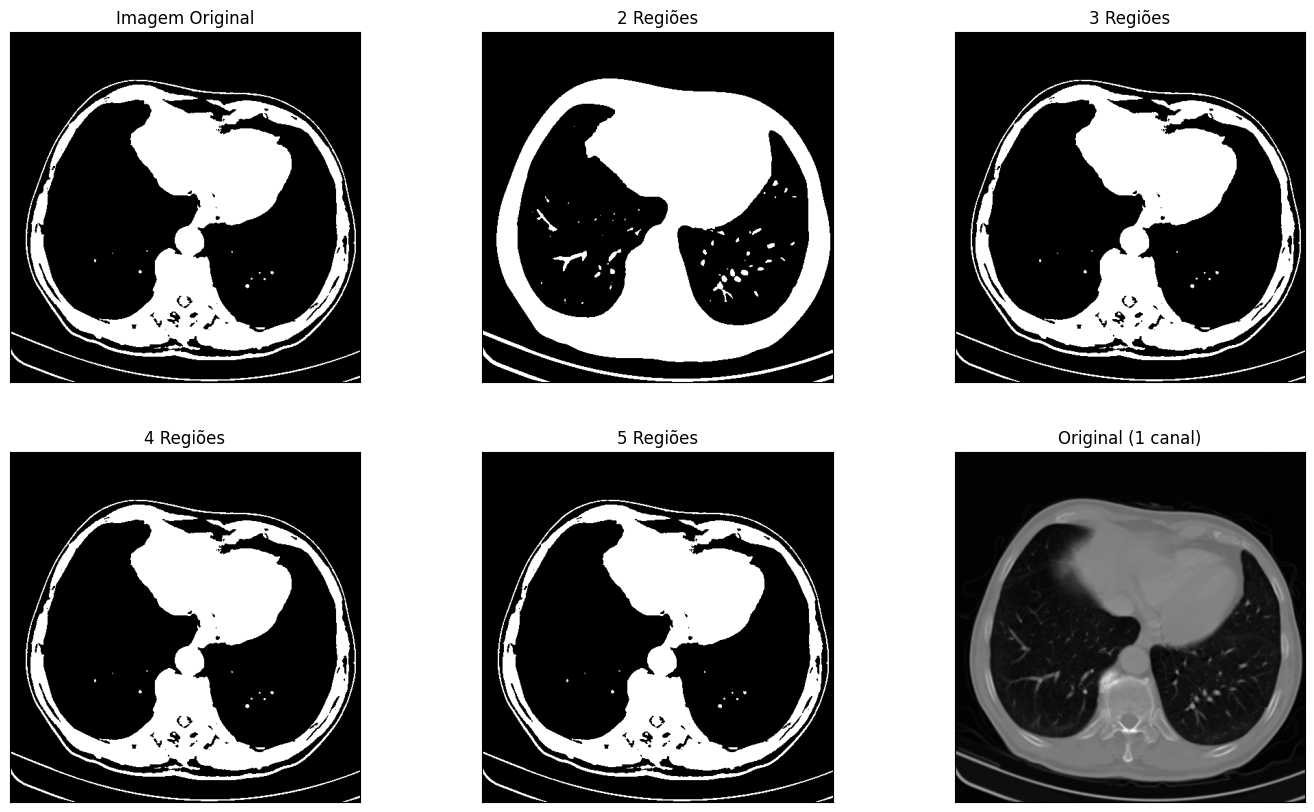

In [25]:
img2 = imread('/content/gdrive/MyDrive/Segmentacao/medical-images/tiff_images/ID_0003_AGE_0075_CONTRAST_1_CT.tif')
segmentacao_regiao(img2)

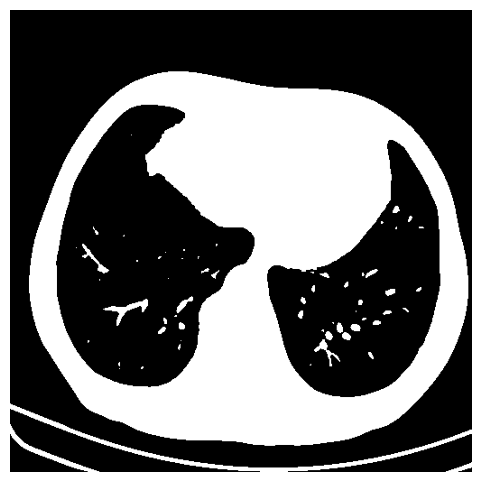

In [26]:
img2 = imread('/content/gdrive/MyDrive/Segmentacao/medical-images/tiff_images/ID_0003_AGE_0075_CONTRAST_1_CT.tif')
img_float32 = np.float32(img2)

if (checa_imagem_cinza(img_float32) == False):
    gray = rgb2gray(img_float32)
else:
    gray = img_float32

seg2 = segmenta2regioes(gray)
mostrar(seg2)

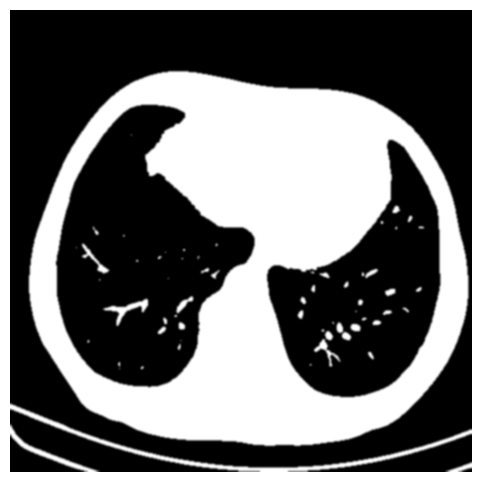

In [27]:
desfoque = cv2.GaussianBlur(seg2, (5,5), 0)
mostrar(desfoque)

# Analise por técnica de Limiarização e Otsu

Valor de limiar Otsu:  102.0


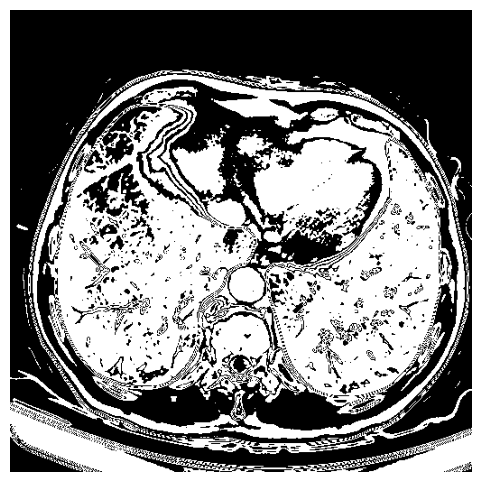

In [28]:
#Otsu
image = gray.astype("uint8")
valor, otsu = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
print('Valor de limiar Otsu: ', valor)
mostrar(otsu)

In [ ]:
#Limiarização

In [29]:
def limiarizacao_adaptativa(img, limiar = 102, block_size = 11, C = 9):
  _, limiar_global = cv2.threshold(img, limiar, 255, cv2.THRESH_BINARY)
  limiar_media = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, block_size, C)
  limiar_gauss = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, block_size, C)

  imagens = [img, limiar_global, limiar_media, limiar_gauss]
  titulos = ['Imagem original', 'Limiarização global', 'Limiarização adaptativa - média', 'Limiarização adaptativa - gaussina']

  fig = plt.gcf()
  fig.set_size_inches(18,12)
  
  for i in range(4):
    plt.subplot(2,2,i+1)
    plt.imshow(cv2.cvtColor(imagens[i], cv2.COLOR_BGR2RGB), cmap='gray')
    plt.title(titulos[i])
    plt.xticks([]),plt.yticks([])

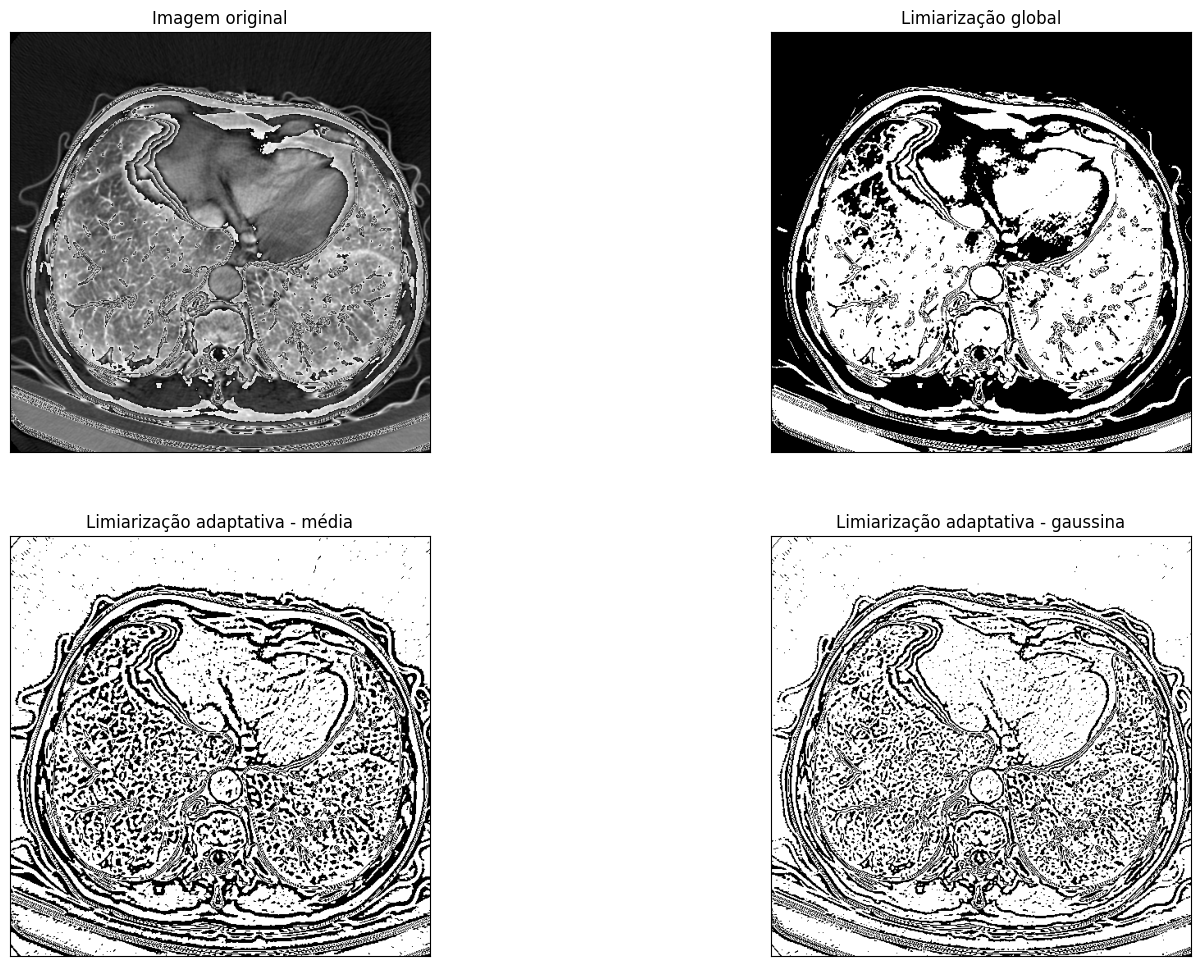

In [30]:
limiarizacao_adaptativa(image)

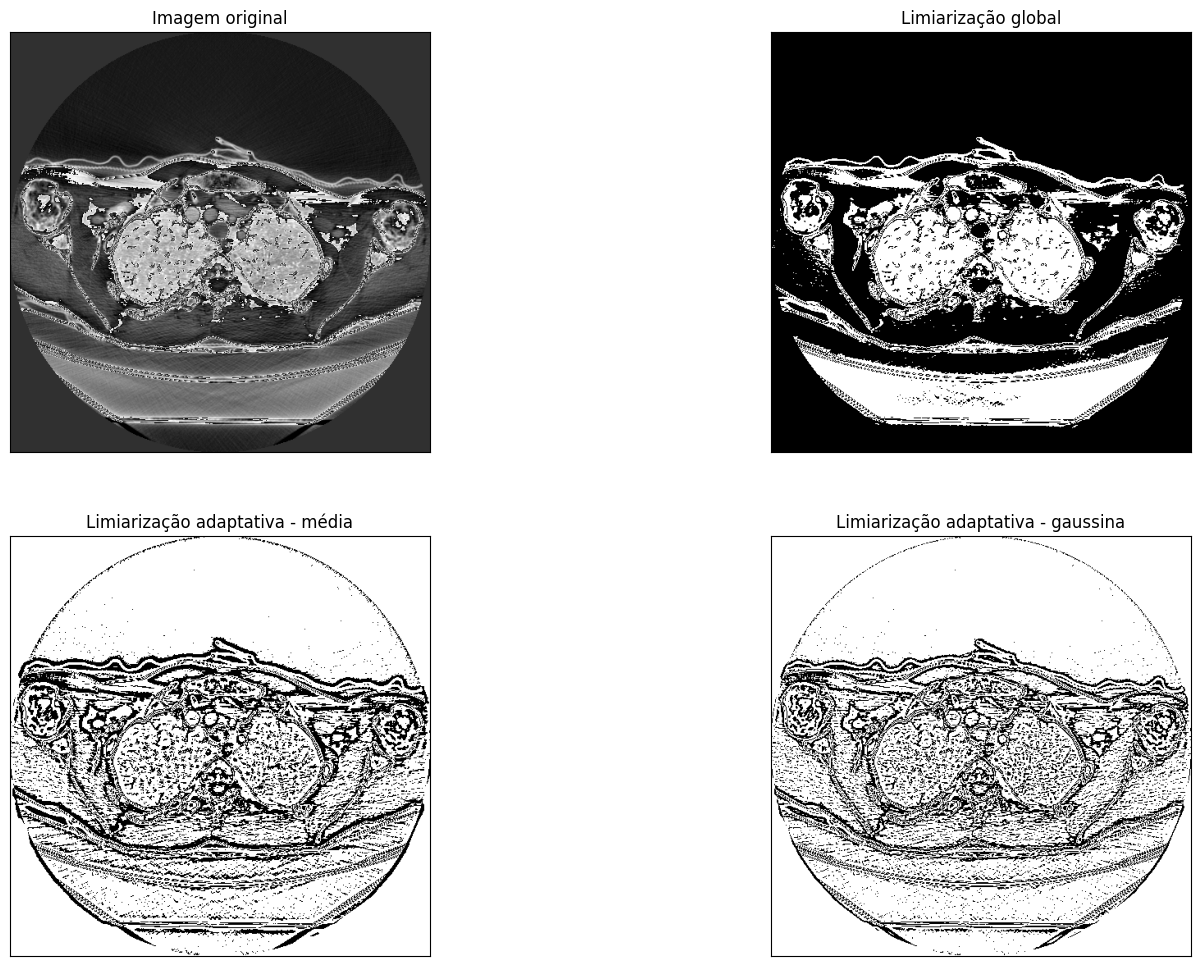

In [31]:
img2 = imread('/content/gdrive/MyDrive/Segmentacao/medical-images/tiff_images/ID_0008_AGE_0051_CONTRAST_1_CT.tif')
img_float32 = np.float32(img2)

if (checa_imagem_cinza(img_float32) == False):
    gray = rgb2gray(img_float32)
else:
    gray = img_float32
    
image = gray.astype("uint8")
limiarizacao_adaptativa(image)

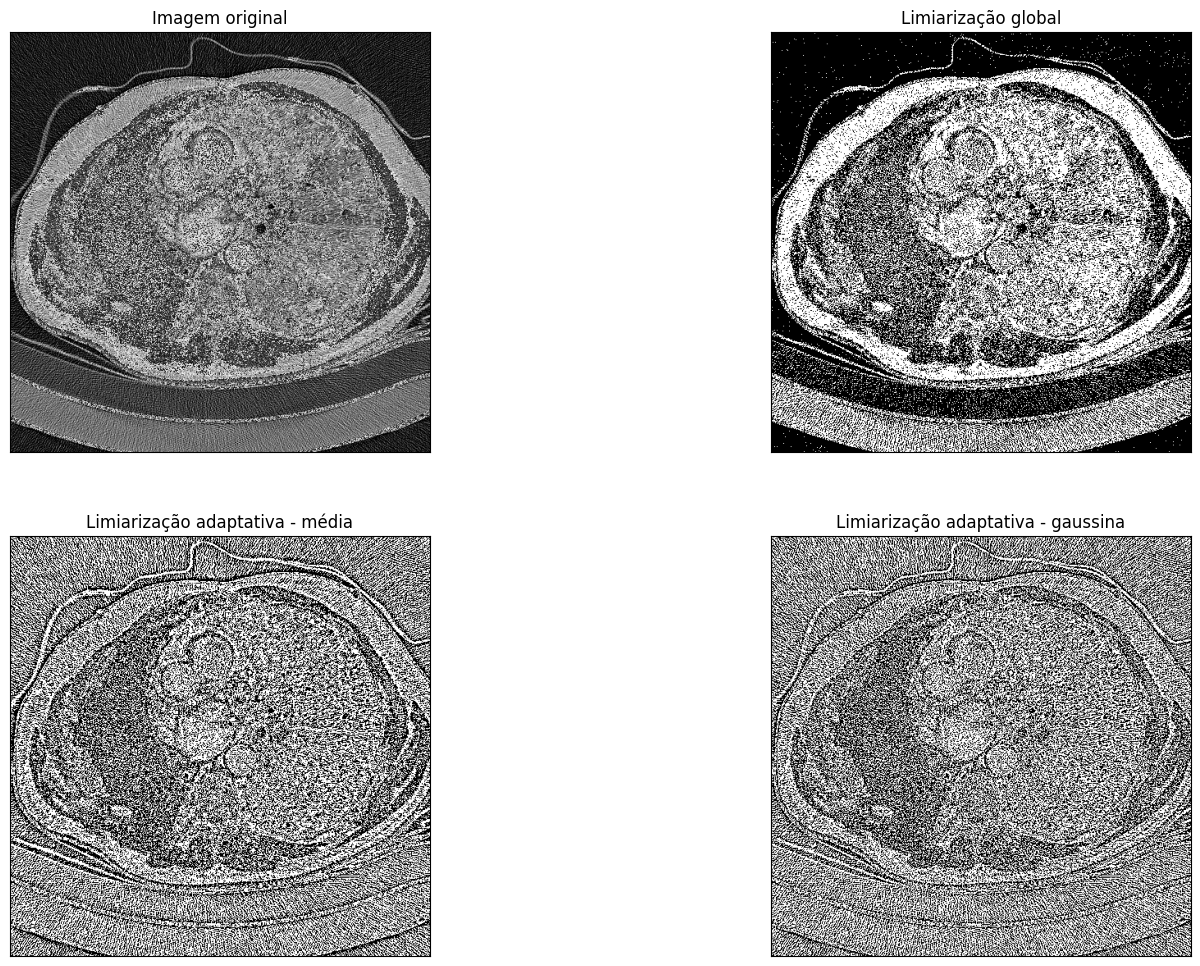

In [32]:
img2 = imread('/content/gdrive/MyDrive/Segmentacao/medical-images/tiff_images/ID_0014_AGE_0071_CONTRAST_1_CT.tif')
img_float32 = np.float32(img2)

if (checa_imagem_cinza(img_float32) == False):
    gray = rgb2gray(img_float32)
else:
    gray = img_float32
    
image = gray.astype("uint8")
limiarizacao_adaptativa(image)

# Analise baseada em bordas

In [33]:
def segmentacao_bordas(img):
  desfoque = cv2.GaussianBlur(img, (5, 5), 0)
  
  sobel_x = cv2.Sobel(desfoque, cv2.CV_64F, 1, 0, ksize=3)
  sobel_y = cv2.Sobel(desfoque, cv2.CV_64F, 0, 1, ksize=3)
  sobel_x = cv2.convertScaleAbs(sobel_x)
  sobel_y = cv2.convertScaleAbs(sobel_y)
  sobel = cv2.addWeighted(src1=sobel_x, alpha=0.5, src2=sobel_y, beta=0.5, gamma=0)
  
  desfoqueCopy = np.uint8(desfoque)
  canny = cv2.Canny(desfoqueCopy, 80, 140)
 
  kernel = np.ones((3, 3), np.uint8)  
  
  dilatacao = cv2.dilate(canny, kernel, iterations=2)
  erosao = cv2.erode(dilatacao, kernel, iterations=1)

  imagens = [img, sobel, canny, erosao]
  titulos = ['Imagem Original', 'Sobel', 'Canny Edge', 'Canny Edge + Fechamento']

  fig = plt.gcf()
  fig.set_size_inches(18, 12)

  for i in range(4):
      plt.subplot(2,2,i+1)
      plt.imshow(cv2.cvtColor(imagens[i], cv2.COLOR_BGR2RGB), 'gray')
      plt.title(titulos[i])
      plt.xticks([]),plt.yticks([]) 
      plt.subplots_adjust(wspace=0.1) 

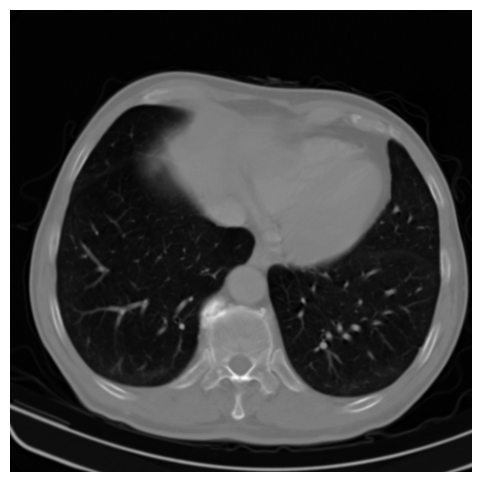

In [34]:
img3 = imread('/content/gdrive/MyDrive/Segmentacao/medical-images/tiff_images/ID_0003_AGE_0075_CONTRAST_1_CT.tif')
img_float32 = np.float32(img3)

if (checa_imagem_cinza(img_float32) == False):
    gray = rgb2gray(img_float32)
else:
    gray = img_float32
    
mostrar(gray)

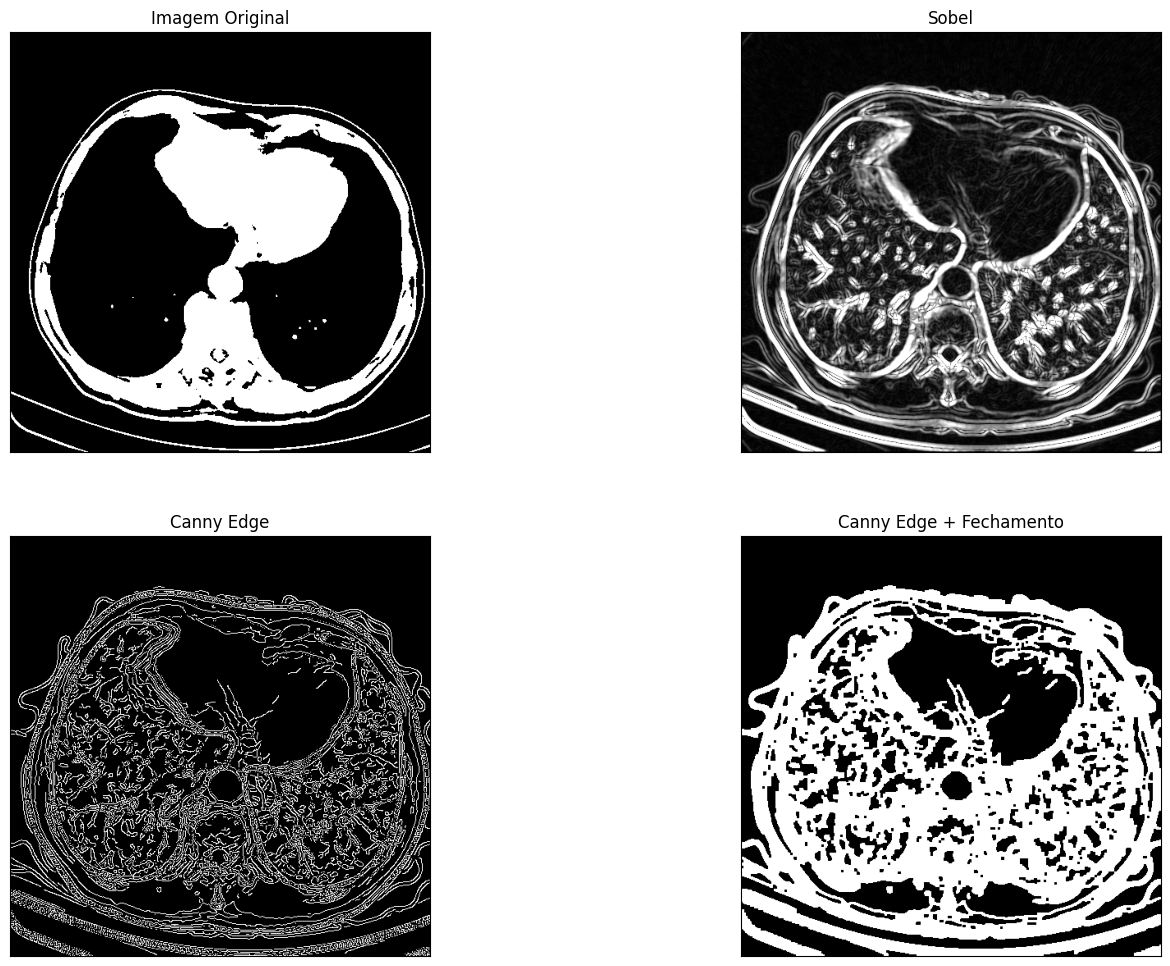

In [35]:
segmentacao_bordas(gray)

De todos os estudos feitos a que ficou melhor foi a limiarização média para as imagens em questão, sendo assim, será gerado as imagens da mask a partir dela

In [36]:
def limiarizacao_media(img): 
  img_float32 = np.float32(img)
  gray = rgb2gray(img_float32)
  image = gray.astype("uint8")
  limiar_media = cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 11, 9)
  return limiar_media

In [ ]:
folder_old = '/content/gdrive/MyDrive/Segmentacao/medical-images/tiff_images/'
folder_new = '/content/gdrive/MyDrive/Segmentacao/medical-images/jpg_images/'

In [ ]:
# Apaga os arquivos mask na pasta se precisar
for f in os.listdir(folder_new):
    os.remove(os.path.join(folder_new, f))

# Salva os arquivos da mask na pasta jpg_images

In [ ]:
for filename in os.listdir(folder_old):
    #Leitura do arquivo
    img = imread(os.path.join(folder_old,filename))    

    if img is not None:
      #cria a imagem aplicando a limiarizacao média
      limiar_media = limiarizacao_media(img)    

      #gera o caminho do arquivo mask
      arquivo = os.path.join(folder_new, 'MASK_' + filename.replace('.tif', '.jpg'))      

      #Salva o arquivo mask no drive
      cv2.imwrite(arquivo, limiar_media)

<ipython-input-3-4de2be8cb128>:3: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  gray = rgb2gray(img_float32)
